In [103]:
import torch
from  cartopy import crs as ccrs
from matplotlib import pyplot as plt
from matplotlib import rc, colors
import numpy as np
import xarray as xr
from metpy.plots import colortables

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi']= 300

precip_clevs = [0, 0.01, 0.5, 1, 2, 4, 8, 16, 32]
precip_cmap = colors.ListedColormap(
    colortables["precipitation"][: len(precip_clevs) - 1],
    "precipitation",
)
precip_cmap.set_over(
    colortables["precipitation"][len(precip_clevs) - 1]
)
precip_norm = colors.BoundaryNorm(precip_clevs, precip_cmap.N)

latitudes = xr.DataArray(np.load('latitude.npy'), dims = ('y', 'x'))
longitudes = xr.DataArray(np.load('longitude.npy'), dims = ('y', 'x'))
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)

samples = torch.load("samples.pt", map_location=torch.device('cpu'))

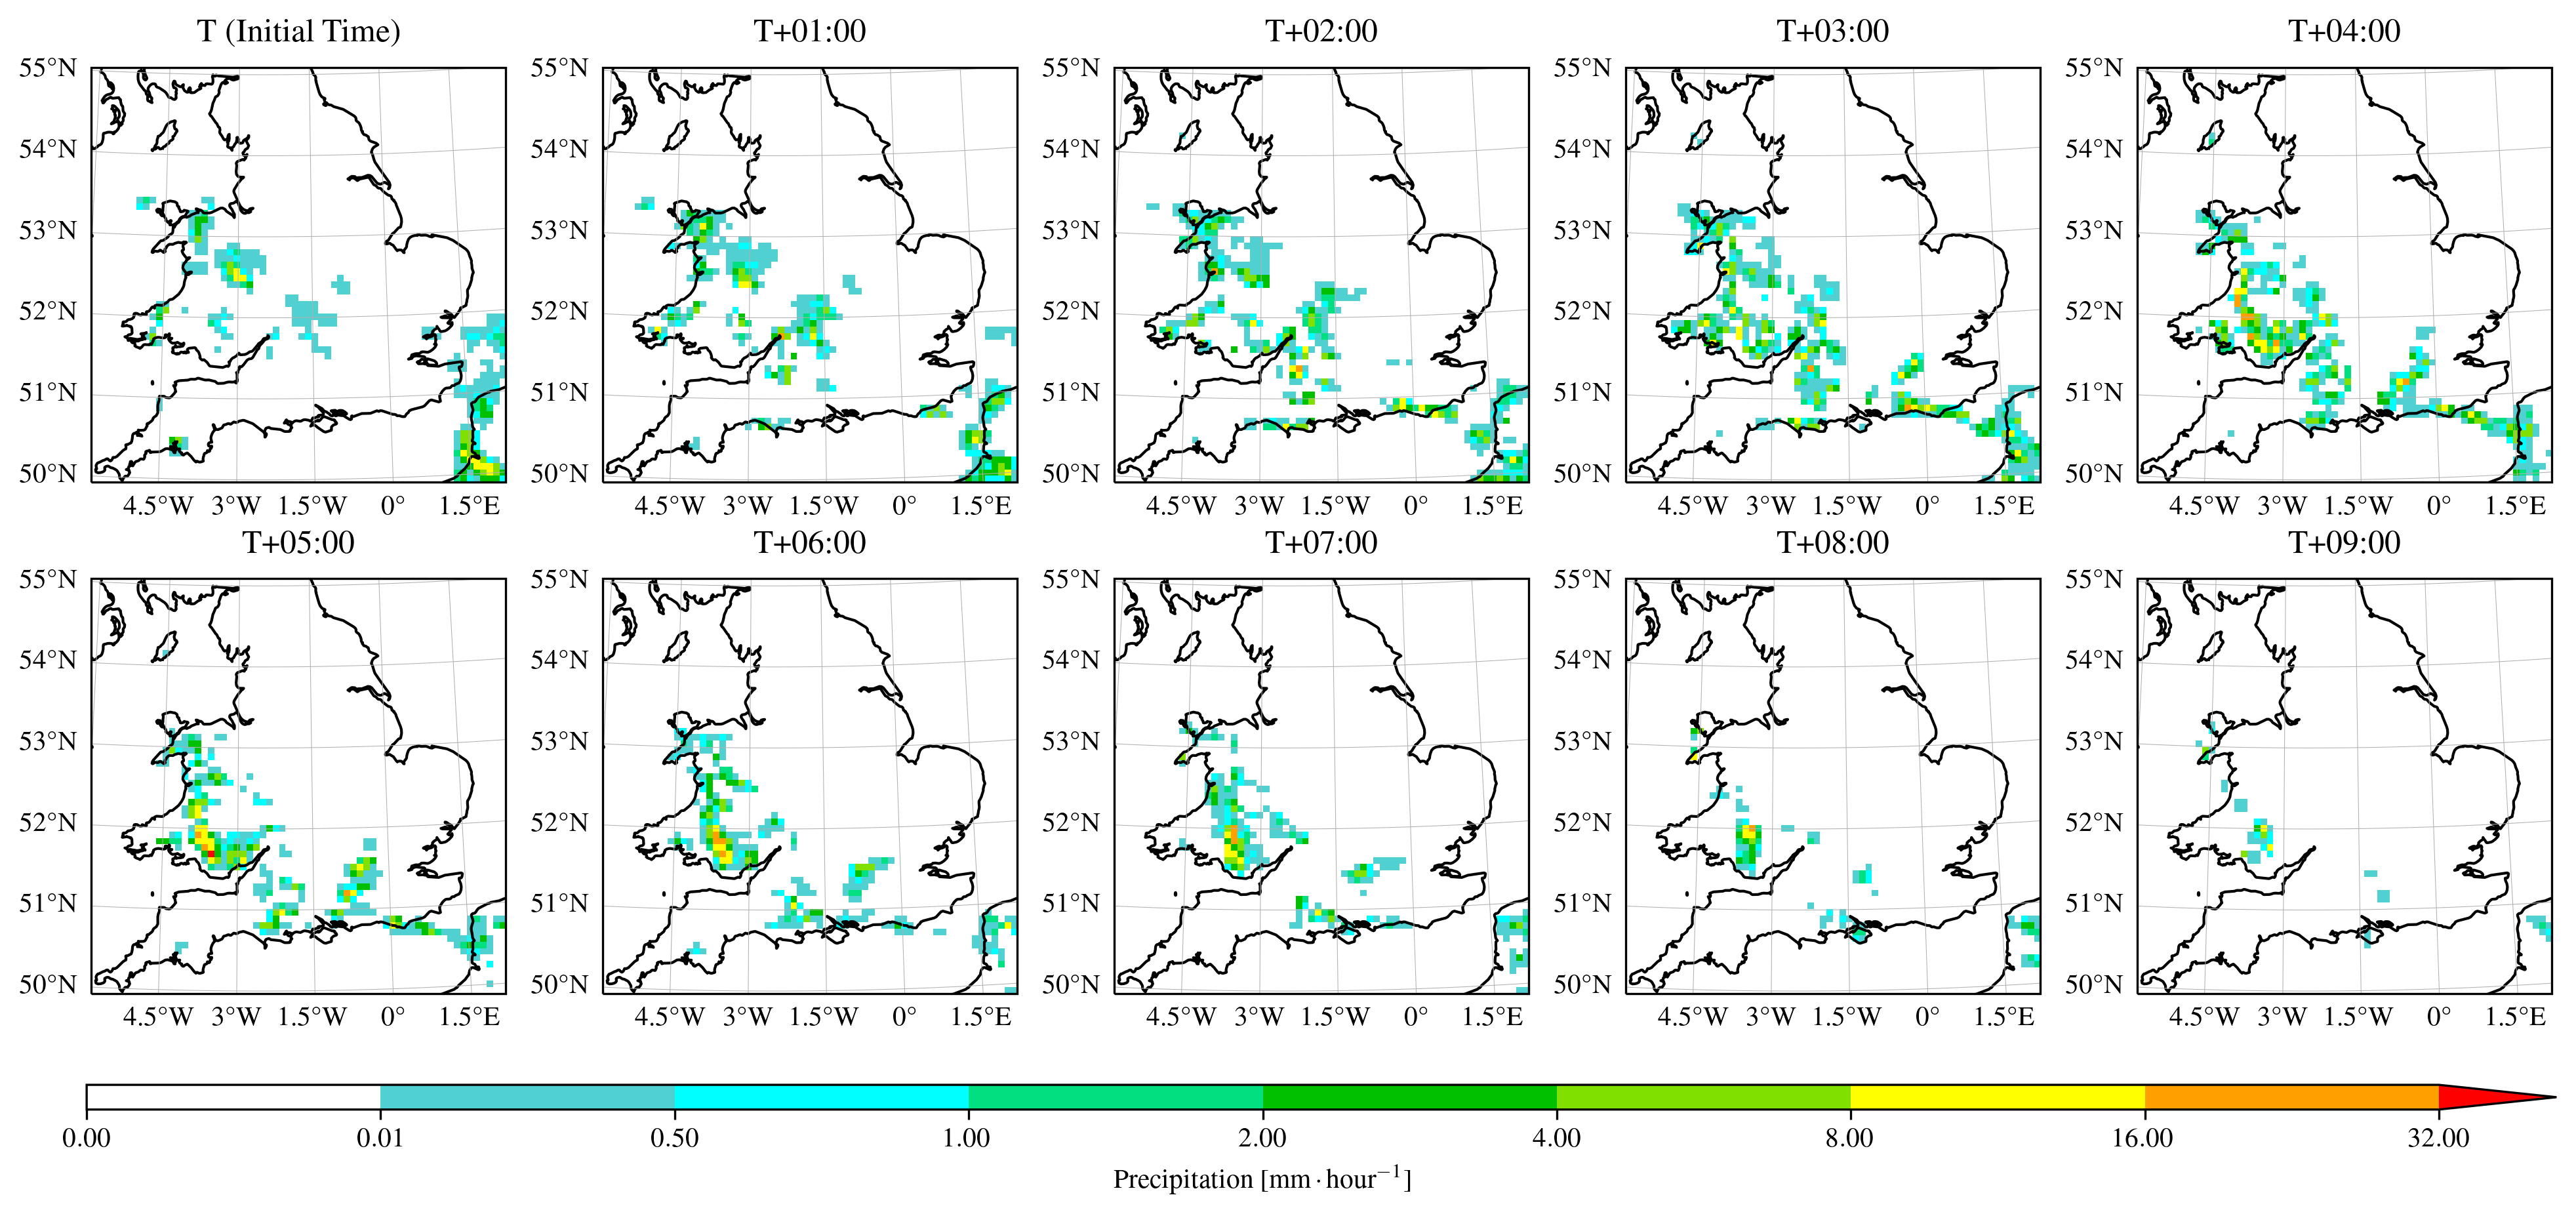

In [102]:
def plot_sample(sample):
    fig, axes = plt.subplots(
        nrows=2,
        ncols=5,
        figsize=(13, 6),
        layout = "constrained",
        subplot_kw={'projection': cp_model_rotated_pole},
    )

    for i, ax in enumerate(axes.flat):
        im = sample.isel(time=i).plot.pcolormesh(
            ax=ax, 
            x = 'longitude', 
            y = 'latitude',
            cmap = precip_cmap,
            norm = precip_norm,
            extend = 'max',
            transform=ccrs.PlateCarree(),
            add_colorbar = False,
        )
        ax.gridlines(linewidth = 0.25, draw_labels={"bottom": "x", "left": "y"}, x_inline=False, y_inline=False)
        ax.coastlines(resolution='10m')
        if i == 0:
            ax.set_title(f"T (Initial Time)")
        else:
            ax.set_title(f"T+0{i}:00")

    fig.colorbar(
        im, 
        ax = axes, 
        orientation="horizontal", 
        aspect=100, 
        # shrink = 1,
        label='Precipitation [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]',
    )

    plt.show()

sample = samples[392][0]

da = xr.DataArray(sample, dims=('time', 'y', 'x'), coords={'latitude': latitudes, 'longitude': longitudes})
plot_sample(da)

In [106]:
# 10 frames with the highest max and mean values

videos_flattened = samples.reshape(-1, 10 * 64 * 64)
maxes = torch.sort(torch.amax(videos_flattened, dim=1), descending = True)
means = torch.sort(torch.mean(videos_flattened, dim=1), descending = True)

maxes_pairs = [(i.item(), j.item()) for i, j in zip(maxes.indices, maxes.values)]
means_pairs = [(i.item(), j.item()) for i, j in zip(means.indices, means.values)]

print("Max individual cells")
for i in range(10):
    print(f"Index: {maxes_pairs[i][0]}, Value: {maxes_pairs[i][1]:.2f}", end = "    ")

print("\n\nMax mean cells")
for i in range(10):
    print(f"Index: {means_pairs[i][0]}, Value: {means_pairs[i][1]:.2f}", end = "    ")

Max individual cells
Index: 392, Value: 36.19    Index: 739, Value: 33.48    Index: 21, Value: 31.06    Index: 792, Value: 30.15    Index: 301, Value: 29.93    Index: 357, Value: 29.62    Index: 63, Value: 29.06    Index: 252, Value: 27.09    Index: 979, Value: 26.58    Index: 607, Value: 26.15    

Max mean cells
Index: 673, Value: 1.64    Index: 51, Value: 1.38    Index: 560, Value: 1.28    Index: 1029, Value: 1.09    Index: 58, Value: 0.94    Index: 619, Value: 0.84    Index: 423, Value: 0.79    Index: 111, Value: 0.78    Index: 188, Value: 0.75    Index: 13, Value: 0.70    